In [1]:
import pandas as pd
from pandas import DataFrame
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from math import sqrt
from numpy import ndarray
import math
import matplotlib.pyplot as plt
import timeit

- The `KNeighborsClassifier` is used only for comparing my KNN implementation against the built in one for correctness

In [2]:
from sklearn.neighbors import KNeighborsClassifier # used only for comparing with the custom implementation

**NOTE**
- `del` is used to delete variables
  - This has been used to remove variables once they are not needed anymore to avoid bugs were variables have not been updated hence returning the wrong data 
  - This means that to run a cell from a subsection, the entire subsection will need to be rerun to regenerate the variables
  - All the subsections have been labelled properly using subheadings

# Algorithms

## Sorting Algorithms

- This class contains various methods to carry out different sorting algorithms 
- Some algorithms are more efficient than others which are explored at the end of this notebook

In [3]:
class Sorting:
	@staticmethod
	def arg_sort(seq: list) -> list:
		# return np.argsort(seq)
		return sorted(range(len(seq)), key=seq.__getitem__)

	@staticmethod
	def merge_sort(seq: list) -> list:
		if len(seq) <= 1:
			return seq
		mid = len(seq) // 2
		left = Sorting.merge_sort(seq[:mid])
		right = Sorting.merge_sort(seq[mid:])
		return Sorting.merge(left, right)

	@staticmethod
	def merge(left: list, right: list) -> list:
		result = []
		while len(left) > 0 and len(right) > 0:
			if left[0] <= right[0]:
				result.append(left.pop(0))
			else:
				result.append(right.pop(0))
		if len(left) > 0:
			result.extend(left)
		if len(right) > 0:
			result.extend(right)
		return result

	@staticmethod
	def quick_sort(seq: list) -> list:
		if len(seq) <= 1:
			return seq
		pivot = seq.pop()
		left = []
		right = []
		for item in seq:
			if item <= pivot:
				left.append(item)
			else:
				right.append(item)
		return Sorting.quick_sort(left) + [pivot] + Sorting.quick_sort(right)

	@staticmethod
	def bubble_sort(seq: list) -> list:
		for i in range(len(seq)):
			for j in range(i + 1, len(seq)):
				if seq[i] > seq[j]:
					seq[i], seq[j] = seq[j], seq[i]
		return seq

	@staticmethod
	def selection_sort(seq: list) -> list:
		for i in range(len(seq)):
			min_index = i
			for j in range(i + 1, len(seq)):
				if seq[j] < seq[min_index]:
					min_index = j
			seq[i], seq[min_index] = seq[min_index], seq[i]
		return seq

	@staticmethod
	def insertion_sort(seq: list) -> list:
		for i in range(1, len(seq)):
			j = i
			while j > 0 and seq[j] < seq[j - 1]:
				seq[j], seq[j - 1] = seq[j - 1], seq[j]
				j -= 1
		return seq

	@staticmethod
	def heap_sort(seq: list) -> list:
		heap = []
		for item in seq:
			heap.append(item)
			Sorting.sift_up(heap, len(heap) - 1)
		result = []
		while len(heap) > 0:
			result.append(heap[0])
			heap[0] = heap[-1]
			heap.pop()
			Sorting.sift_down(heap, 0)
		return result	

	@staticmethod
	def sift_up(heap: list, index: int) -> None:
		while index > 0:
			parent = (index - 1) // 2
			if heap[parent] < heap[index]:
				heap[parent], heap[index] = heap[index], heap[parent]
				index = parent
			else:
				break

	@staticmethod
	def sift_down(heap: list, index: int) -> None:
		while 2 * index + 1 < len(heap):
			left = 2 * index + 1
			right = 2 * index + 2
			child = left
			if right < len(heap) and heap[right] > heap[left]:
				child = right
			if heap[index] < heap[child]:
				heap[index], heap[child] = heap[child], heap[index]
				index = child
			else:
				break

	@staticmethod
	def arg_partition(seq: list) -> list:
		return np.argpartition(seq, 0)

## Nearest Neighbour Algorithms

### K-Nearest Neighbour

- Complexity of $O(n)$
- Once the `prediction` method is called, a list of predicted labels is returned
  - This is achieved through the help of other methods such as `_predict`
  - Each prediction is appended into a list (the `_predict` method returns ` prediction at a time) 
- The `_predict` method predicts the label one at a time as they are passed as arguments
  - It calculates the distance between the test data point and all training data points by calling the `distance` method and stored them in a list
  - It then sorts the distances in ascending order using the `sort` method and picks the top `k` elements as the closest neighbours and the labels
- The `score` method calculates the accuracy of the model
  - Predicts the labels of the test data and compares the predicted labels with the actual labels.
  - It calls the `accuracy_score` method to compute the accuracy of the predictions
- The `accuracy_score` calculates the accuracy of the predictions
  - It calculates the accuracy by dividing the number of correct predictions by the total number of predictions.
- The `distance` method calculates the distance between two data points
  - It calculates the distance between two data points by calling the `euclidean_distance` method
  - In this case, a list comprehension is used to calculate the distance between the test data point and all training data points
  - For each feature in the data point, calculate the difference between the features of the two data points.
	-	Calculate the square of the difference between the features of the two data points.
	-	Sum the squares of the differences between the features of the two data points.
	-	Calculate the square root of the sum of the squares of the differences between the features of the two data points.
	-	Returns a list of distances between two data points for each combination.
- The `sort` method sorts list in ascending order
  - By default it uses the `arg_sort` as it is very efficient

In [4]:
class K_Nearest_Neighbours:
	def __init__(self, k: int):
		self.k: int = k
		self.X_train: list = None
		self.y_train: list = None

	def fit(self, X_train: list, y_train: list) -> None:
		""" Fit training data.
		
		Args:
			X_train (list): features of training data 
			y_train (list): labels of training data
		"""
		self.X_train = X_train
		self.y_train = y_train

	def predict(self, X_test: list) -> list[int]:
		""" Predict labels of test data. 
		Finds the nearest neighbour for each test data point and returns the label of the nearest neighbour.


		Args:
			X_test (list): features of test data 

		Returns:
			list[int]: labels of test data
		"""	
		predictions: list = []
		for index, element in enumerate(X_test): # for each element in the test set
			predictions.append(self._predict(element)) # predict the label of the element
		return predictions
	
	def _predict(self, x_test: list) -> int:
		""" Predict label of a single test data point.
		Calculates the distance between the test data point and all training data points and returns the label of the nearest neighbour.
		Finds the nearest neighbour by sorting the distances and returning the label of the first training data point.
		Gets the label of the nearest neighbour by indexing the label of the training data point with the index of the nearest neighbour.

		Args:
			x_test (list): features of a single test data point

		Returns:
			int: label of a single test data point
		"""	
		distances: list = self.distance(self.X_train, x_test) # calculate the distance between the test data point and all training data points
		k_indices: list = self.sort(distances, "arg_sort")[:self.k] # find the k nearest neighbours
		k_nearest_labels: list = [self.y_train[i] for i in k_indices] # get the labels of the k nearest neighbours
		most_common: list[tuple] = Counter(k_nearest_labels).most_common(1) # get the most common label of the k nearest neighbours 
		return most_common[0][0] # return the most common label of the k nearest neighbours

	def score(self, X_test: list, y_test: list) -> float:
		""" Calculate the accuracy of the model.
		Predicts the labels of the test data and compares the predicted labels with the actual labels.

		Args:
			X_test (list): features of test data
			y_test (list): labels of test data

		Returns:
			float: accuracy of the model
		"""		
		predictions: list = self.predict(X_test) # predict the labels of the test data 
		return self.accuracy_score(y_test, predictions) # calculate the accuracy of the model

	def accuracy_score(self, y_test, y_pred) -> float:
		""" Calculate the accuracy of the predictions.
		Calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""		
		accuracy: float = sum(y_test == y_pred) / len(y_test)
		return accuracy

	def distance(self, x1: list, x2: list) -> list[float]:
		""" Calculate the distance between two data points.
		For each feature in the data point, calculate the difference between the features of the two data points.
		Calculate the square of the difference between the features of the two data points.
		Sum the squares of the differences between the features of the two data points.
		Calculate the square root of the sum of the squares of the differences between the features of the two data points.
		Return the distance between the two data points.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""	
		return [((sum((x1 - x2)**2)) ** 0.5) for (x1) in (self.X_train)] # calculate the distance between the test data point and all training data points

	def sort(self, distances: list, sorting_type: str = "arg_sort"):
		""" Sort the distances from smallest to largest.
		The sorting type determines the method used to sort the distances.
		The type passed determines the method used to sort the distances.

		Args:
			distances (list): distances to be sorted
			sorting_type (str): type of sorting to be used. Defaults to "arg_sort".

		Returns:
			list: sorted distances
		"""	
		if sorting_type == "arg_sort":
			return Sorting.arg_sort(distances)
		elif sorting_type == "merge_sort":
			return Sorting.merge_sort(distances)
		elif sorting_type == "quick_sort":
			return Sorting.quick_sort(distances)

### 1-Nearest Neighbour

In [5]:
class One_Nearest_Neighbours:
	def __init__(self):
		self.k: int = 1
		self.X_train: list = None
		self.y_train: list = None

	def fit(self, X_train: list, y_train: list) -> None:
		""" Fit training data.

		Args:
			X_train (list): features of training data 
			y_train (list): labels of training data
		"""
		self.X_train = X_train
		self.y_train = y_train

	def predict(self, X_test: list) -> list[int]:
		""" Predict labels of test data. 
		Finds the nearest neighbour for each test data point and returns the label of the nearest neighbour.


		Args:
			X_test (list): features of test data 

		Returns:
			list[int]: labels of test data
		"""		
		predictions: list = []
		for index, element in enumerate(X_test): # for each element in the test set 
			predictions.append(self._predict(element)) # predict the label of the element
		return predictions
	
	def _predict(self, x_test: list) -> int:
		""" Predict label of a single test data point.
		Calculates the distance between the test data point and all training data points and returns the label of the nearest neighbour.
		Finds the nearest neighbour by sorting the distances and returning the label of the first training data point.
		Gets the label of the nearest neighbour by indexing the label of the training data point with the index of the nearest neighbour.

		Args:
			x_test (list): features of a single test data point

		Returns:
			int: label of a single test data point
		"""		
		distances: list = self.distance(self.X_train, x_test) # calculate the distance between the test data point and all training data points
		k_indices: list = self.sort(distances, "arg_sort")[:self.k] # find the k nearest neighbours from the sorted distances
		k_nearest_labels: list = [self.y_train[i] for i in k_indices] # get the labels of the k nearest neighbours 
		most_common: list[tuple] = Counter(k_nearest_labels).most_common(1) # find the most common label among the k nearest neighbours
		return most_common[0][0] # return the most common label

	def score(self, X_test: list, y_test: list) -> float:
		""" Calculate the accuracy of the model.
		Predicts the labels of the test data and compares the predicted labels with the actual labels.
		Calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

		Args:
			X_test (list): features of test data
			y_test (list): labels of test data

		Returns:
			float: accuracy of the model
		"""		
		predictions: list = self.predict(X_test) # predict the labels of the test data
		return self.accuracy_score(y_test, predictions) # calculate the accuracy of the predictions

	def accuracy_score(self, y_test: list, y_pred: list) -> float:
		""" Calculate the accuracy of the predictions.
		Calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""		
		accuracy: float = sum(y_test == y_pred) / len(y_test) # calculate the accuracy by dividing the number of correct predictions by the total number of predictions
		return accuracy 

	def distance(self, x1: list, x2: list) -> list[float]:
		""" Calculate the distance between two data points.
		For each feature in the data point, calculate the difference between the features of the two data points.
		Calculate the square of the difference between the features of the two data points.
		Sum the squares of the differences between the features of the two data points.
		Calculate the square root of the sum of the squares of the differences between the features of the two data points.
		Return the distance between the two data points.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""	
		return [((sum((x1 - x2)**2)) ** 0.5) for (x1) in (self.X_train)] # calculate the distance between the test data point and all training data points

	def sort(self, distances: list, sorting_type: str = "arg_sort"):
		""" Sort the distances from smallest to largest.
		The sorting type determines the method used to sort the distances.
		The type passed determines the method used to sort the distances.

		Args:
			distances (list): distances to be sorted
			sorting_type (str): type of sorting to be used. Defaults to "arg_sort".

		Returns:
			list: sorted distances
		"""		
		if sorting_type == "arg_sort":
			return Sorting.arg_sort(distances)
		elif sorting_type == "merge_sort":
			return Sorting.merge_sort(distances)
		elif sorting_type == "quick_sort":
			return Sorting.quick_sort(distances)

### 3-Nearest Neighbours

In [6]:
class Three_Nearest_Neighbours:
	def __init__(self):
		self.k: int = 3
		self.X_train: list = None
		self.y_train: list = None

	def fit(self, X_train: list, y_train: list) -> None:
		""" Fit training data.
		
		Args:
			X_train (list): features of training data 
			y_train (list): labels of training data
		"""
		self.X_train = X_train
		self.y_train = y_train

	def predict(self, X_test: list) -> list[int]:
		""" Predict labels of test data. 
		Finds the nearest neighbour for each test data point and returns the label of the nearest neighbour.


		Args:
			X_test (list): features of test data 

		Returns:
			list[int]: labels of test data
		"""	
		predictions: list = []
		for index, element in enumerate(X_test): # for each element in the test set
			predictions.append(self._predict(element)) # predict the label of the element
		return predictions
	
	def _predict(self, x_test: list) -> int:
		""" Predict label of a single test data point.
		Calculates the distance between the test data point and all training data points and returns the label of the nearest neighbour.
		Finds the nearest neighbour by sorting the distances and returning the label of the first training data point.
		Gets the label of the nearest neighbour by indexing the label of the training data point with the index of the nearest neighbour.

		Args:
			x_test (list): features of a single test data point

		Returns:
			int: label of a single test data point
		"""	
		distances: list = self.distance(self.X_train, x_test)
		k_indices: list = self.sort(distances, "arg_sort")[:self.k]
		k_nearest_labels: list = [self.y_train[i] for i in k_indices]
		most_common: list[tuple] = Counter(k_nearest_labels).most_common(1)
		return most_common[0][0]

	def score(self, X_test: list, y_test: list) -> float:
		""" Calculate the accuracy of the model.
		Predicts the labels of the test data and compares the predicted labels with the actual labels.
		Calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

		Args:
			X_test (list): features of test data
			y_test (list): labels of test data

		Returns:
			float: accuracy of the model
		"""		
		predictions: list = self.predict(X_test)
		return self.accuracy_score(y_test, predictions)

	def accuracy_score(self, y_test, y_pred) -> float:
		""" Calculate the accuracy of the predictions.
		Calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""		
		accuracy: float = sum(y_test == y_pred) / len(y_test)
		return accuracy

	def distance(self, x1: list, x2: list) -> list[float]:
		""" Calculate the distance between two data points.
		For each feature in the data point, calculate the difference between the features of the two data points.
		Calculate the square of the difference between the features of the two data points.
		Sum the squares of the differences between the features of the two data points.
		Calculate the square root of the sum of the squares of the differences between the features of the two data points.
		Return the distance between the two data points.

		Args:
			y_test (list): labels of test data
			y_pred (list): predicted labels of test data

		Returns:
			float: accuracy of the predictions
		"""		
		return [((sum((x1 - x2)**2)) ** 0.5) for (x1) in (self.X_train)]

	def sort(self, distances, sorting_type = "arg_sort"):
		""" Sort the distances from smallest to largest.
		The sorting type determines the method used to sort the distances.
		The type passed determines the method used to sort the distances.

		Args:
			distances (list): distances to be sorted
			sorting_type (str): type of sorting to be used. Defaults to "arg_sort".

		Returns:
			list: sorted distances
		"""		
		if sorting_type == "arg_sort":
			return Sorting.arg_sort(distances)
		elif sorting_type == "merge_sort":
			return Sorting.merge_sort(distances)
		elif sorting_type == "quick_sort":
			return Sorting.quick_sort(distances)

## Conformal Predictor

- Complexity of $O(log(n^2))$
 $$ \frac{distance to the nearest sample of a different class}{the distance to the nearest sample of the same class} $$
- For each distance calculated, the class of the point is current point is checked against the other class
  - If the classes are the same, then the variable tracking the closest distance between the same classes is update
  - If the classes are different, then the variable tracking the closest distance between different classes is update
- The `calculate_p_value` function calculates the p-values by using the formula for each distance between the same class and different class on by one (from the list)
- The `calculate_alpha` function calculates the alpha value of the data by multiplying the the number of training data points by the desired rate (normally 5%)
- The `calculate_conformal_prediction` function calculates the conformal prediction of each test point 
  - The shortest distances between the same classes and different classes are required along with the p-values
  - For each test data point, calculate the p-value by dividing the distance between the test data point and the training data point by the sum of the distance between the test data point and the training data point and the distance between the test data point and the training data point (using formula)
  - The predictions are added to a list if they are above alpha

In [7]:
def calculate_distance(X_train: list, y_train: list) -> tuple[list[float]]:
    """ Calculate the distance between each point in the training set and each point in the test set.
    Updates the corresponding variables depending on whether they are the same class or different class. 

    Args:
        X_train (list): features of training data
        y_train (list): labels of training data

    Returns:
        tuple[list[float]]: shortest distance between same class and different class
    """    
    train_length: int = X_train.shape[0] # get the number of training data points
    same_class_dist, other_class_dist = [[math.inf for i in range(train_length)] for j in range(2)] # initialise the distances to infinity

    for i in range(train_length - 1): # for each training data point
        for j in range(i+1, train_length): # for each training data point
            dist = np.sqrt(np.sum((X_train[i] - X_train[j]) ** 2)) # calculate the distance between the two training data points
            if y_train[i] == y_train[j]: # if the two training data points are of the same class
                if dist < same_class_dist[i]: # if the distance is less than the current minimum distance
                    same_class_dist[i] = dist # update the minimum distance
                if dist < same_class_dist[j]: # if the distance is less than the current minimum distance
                    same_class_dist[j] = dist # update the minimum distance
            else: # if the two training data points are of different classes
                if dist < other_class_dist[i]: # if the distance is less than the current minimum distance
                    other_class_dist[i] = dist # update the minimum distance
                if dist < other_class_dist[j]: # if the distance is less than the current minimum distance
                    other_class_dist[j] = dist # update the minimum distance
    return same_class_dist, other_class_dist # return the minimum distances

def calculate_p_value(same_class_dist: list[float], other_class_dist: list[float]) -> list[float]:
    """ Calculate the p-value for each training data point.
    For each element in the same class distance list, calculate the p-value by dividing the element by the corresponding element in the other class distance list (using formula). 

    Args:
        same_class_dist (list[float]): _description_
        other_class_dist (list[float]): _description_

    Returns:
        list[float]: _description_
    """    
    p_values: list[float] = [] # initialise the p-values
    for element_same, element_other in zip(same_class_dist, other_class_dist): # for each minimum distance
        p_values.append(element_same / (element_other + element_same)) # calculate the p-value
    return p_values 

def calculate_alpha(p_values: list[float], alpha: float) -> float:
    """ Calculate the alpha value.
    Alpha is calculated by multiplying the number of training data points by the alpha value passed.

    Args:
        p_values (list[float]): p-values of the training data points
        alpha (float): alpha value

    Returns:
        float: alpha value
    """    
    p_values.sort() # sort the p-values
    return p_values[int(len(p_values) * alpha)] # return the alpha value

def calculate_conformal_prediction(X_train: list, y_train: list, X_test: list, alpha: float) -> list[bool]: 
    """ Calculate the conformal prediction for each test data point.
    Distances and p-values are calculated for each training data point.
    For each test data point, calculate the p-value by dividing the distance between the test data point and the training data point by the sum of the distance between the test data point and the training data point and the distance between the test data point and the training data point (using formula).

    Args:
        X_train (list): features of training data
        y_train (list): labels of training data
        X_test (list): features of test data
        alpha (float): alpha value

    Returns:
        list[bool]: predicted labels 
    """    
    same_class_dist, other_class_dist = calculate_distance(X_train, y_train) # calculate the minimum distances
    p_values: list[float] = calculate_p_value(same_class_dist, other_class_dist) # calculate the p-values
    alpha: float = calculate_alpha(p_values, alpha) # calculate the alpha value
    predictions: list[bool] = [] 
    for index, element in enumerate(X_test): # for each test data point
        dist = np.sqrt(np.sum((X_train - element) ** 2)) # calculate the distance between the test data point and all training data points
        p_values = dist / (dist + other_class_dist) # calculate the p-values
        predictions.append(p_values > alpha) # append the prediction to the list of predictions
    return predictions

def error_rate(y_test: list, predictions: list) -> float:
    return sum(y_test != predictions) / len(y_test)

# Useful Functions

- This function prints some useful properties for a dataset after running some Nearest Neighbour algorithm
- It prints:
  - A list of predictions 
  - Accuracy of the model
  - A table comparing the predicted data with the actual data
  - Total number of errors

In [8]:
def print_dataset_properties(predictions: list, accuracy: float, compare: DataFrame, total_number_of_errors_iris: int) -> None:
	""" Print the properties of the dataset.
	It prints the predictions, accuracy, error rate, total errors and compares the labels predicted against actual labels.

	Args:
		predictions (list): predicted labels of test data
		accuracy (float): accuracy of the predictions
		compare (DataFrame): containing the actual and predicted labels of the test data side by side in a table
		total_number_of_errors_iris (int): total number of errors in the predictions
	"""	
	print("Predictions: ", predictions)
	print("Accuracy: ", accuracy)
	print("Error Rate: ", 1 - accuracy)
	print("Total Number of Errors: ", total_number_of_errors_iris)
	print("Compare: ", compare)

- This function checks whether 2 lists are the same by comparing each element one by one
- It keeps track of the current elements being compared
- As soon as an element is different, false is returned terminating the function
- The loop will keep going as long as the elements are the same until there are no more element to compare in which case true is returned

In [9]:
def compare_lists(list_1: list, list_2: list) -> bool:
	""" Compare two lists element by element.
	Iterates through the lists and compares each element keeping track to whether they are the same
	As soon as an element is not the same, the function returns False

	Args:
		list_1 (list): list to be compared
		list_2 (list): list to be compared

	Returns:
		bool: whether the lists are the same
	"""	
	compare: bool = True
	for x, y in zip(list_1, list_2):
		compare = (x == y)
		if not compare:
			return False
	return compare

- This function computes the mean/average of a list
- It divides the total number of elements by the sum

In [10]:
def mean(lst: list[int, float]) -> float:
	""" Calculate the mean of a list.

	Args:
		lst (list[int, float]): list of numbers

	Returns:
		float: mean/average of the list
	"""	
	return sum(lst) / len(lst)

# Datasets

## Iris

### Loading Dataset

In [11]:
iris = load_iris()

### Splitting Dataset

In [12]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris['data'], iris['target'], random_state=2022) # 75% training and 25% test 

### Checking Dataset

- Prints the dimensions of the dataset after splitting

In [13]:
# print(X_train_iris)
# print(y_train_iris)

### Checking Nearest Neighbours Algorithms

#### K-Nearest Neighbours 

##### `K = 3`

- The K-Nearest algorithm is initialized and 3 is passed as the number of neighbours required
- The the 2 sets that need to be tested are passed (fit)

In [14]:
k_nearest_neighbour_iris: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3) # k = 3
k_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [15]:
predictions_iris: list = k_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
compare_iris: DataFrame = pd.DataFrame({'True Labels': y_test_iris, 'Predicted Labels': predictions_iris}) # compare the predicted labels with the actual labels
accuracy_iris: float = k_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions
error_rate_iris: float = 1 - accuracy_iris # calculate the error rate of the predictions
total_number_of_errors_iris: int = sum(y_test_iris != predictions_iris) # calculate the total number of errors in the predictions

In [16]:
print_dataset_properties(predictions_iris, accuracy_iris, compare_iris, total_number_of_errors_iris)

Predictions:  [2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy:  0.9736842105263158
Error Rate:  0.02631578947368418
Total Number of Errors:  1
Compare:      True Labels  Predicted Labels
0             2                 2
1             2                 2
2             0                 0
3             2                 2
4             0                 0
5             0                 0
6             1                 1
7             1                 1
8             0                 0
9             1                 1
10            1                 1
11            2                 2
12            1                 1
13            2                 2
14            2                 2
15            0                 0
16            1                 1
17            2                 2
18            2                 2
19            1                 1
20            0                 0
21            0        

##### `K = 1`

- The K-Nearest algorithm is initialized and 1 is passed as the number of neighbours required
- The the 2 sets that need to be tested are passed (fit)

In [17]:
k_nearest_neighbour_iris: K_Nearest_Neighbours = K_Nearest_Neighbours(k=1)
k_nearest_neighbour_iris.fit(X_train_iris, y_train_iris)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [18]:
predictions_iris_k: list = k_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
compare_iris_k: DataFrame = pd.DataFrame({'True Labels': y_test_iris, 'Predicted Labels': predictions_iris_k}) # compare the predicted labels with the actual labels
accuracy_iris_k: float = k_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions
error_rate_iris_k: float = 1 - accuracy_iris_k # calculate the error rate of the predictions
total_number_of_errors_iris_k: int = sum(y_test_iris != predictions_iris_k) # calculate the total number of errors in the predictions

In [19]:
print_dataset_properties(predictions_iris_k, accuracy_iris_k, compare_iris_k, total_number_of_errors_iris_k)

Predictions:  [2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy:  0.9736842105263158
Error Rate:  0.02631578947368418
Total Number of Errors:  1
Compare:      True Labels  Predicted Labels
0             2                 2
1             2                 2
2             0                 0
3             2                 2
4             0                 0
5             0                 0
6             1                 1
7             1                 1
8             0                 0
9             1                 1
10            1                 1
11            2                 2
12            1                 1
13            2                 2
14            2                 2
15            0                 0
16            1                 1
17            2                 2
18            2                 2
19            1                 1
20            0                 0
21            0        

In [20]:
del k_nearest_neighbour_iris, predictions_iris, compare_iris, accuracy_iris, error_rate_iris

#### 1-Nearest Neighbour

- The 1-Nearest algorithm is initialized 
- The the 2 sets that need to be tested are passed (fit)

In [21]:
one_nearest_neighbour_iris: One_Nearest_Neighbours = One_Nearest_Neighbours() 
one_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [22]:
predictions_iris: list = one_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
compare_iris: DataFrame = pd.DataFrame({'True Labels': y_test_iris, 'Predicted Labels': predictions_iris}) # compare the predicted labels with the actual labels
accuracy_iris: float = one_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions
error_rate_iris: float = 1 - accuracy_iris # calculate the error rate of the predictions
total_number_of_errors_iris: int = sum(y_test_iris != predictions_iris) # calculate the total number of errors in the predictions

In [23]:
print_dataset_properties(predictions_iris, accuracy_iris, compare_iris, total_number_of_errors_iris)

Predictions:  [2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy:  0.9736842105263158
Error Rate:  0.02631578947368418
Total Number of Errors:  1
Compare:      True Labels  Predicted Labels
0             2                 2
1             2                 2
2             0                 0
3             2                 2
4             0                 0
5             0                 0
6             1                 1
7             1                 1
8             0                 0
9             1                 1
10            1                 1
11            2                 2
12            1                 1
13            2                 2
14            2                 2
15            0                 0
16            1                 1
17            2                 2
18            2                 2
19            1                 1
20            0                 0
21            0        

In [24]:
del one_nearest_neighbour_iris, predictions_iris, compare_iris, accuracy_iris, error_rate_iris

#### 3-Nearest Neighbours

- The 3-Nearest algorithm is initialized 
- The the 2 sets that need to be tested are passed (fit)

In [25]:
three_nearest_neighbours_iris: Three_Nearest_Neighbours = Three_Nearest_Neighbours()
three_nearest_neighbours_iris.fit(X_train_iris, y_train_iris)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [26]:
predictions_iris: list = three_nearest_neighbours_iris.predict(X_test_iris) # predict the labels of the test data
compare_iris: DataFrame = pd.DataFrame({'True Labels': y_test_iris, 'Predicted Labels': predictions_iris}) # compare the predicted labels with the actual labels
accuracy_iris: float = three_nearest_neighbours_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions
error_rate_iris: float = 1 - accuracy_iris # calculate the error rate of the predictions
total_number_of_errors_iris: int = sum(y_test_iris != predictions_iris) # calculate the total number of errors in the predictions

In [27]:
print_dataset_properties(predictions_iris, accuracy_iris, compare_iris, total_number_of_errors_iris)

Predictions:  [2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy:  0.9736842105263158
Error Rate:  0.02631578947368418
Total Number of Errors:  1
Compare:      True Labels  Predicted Labels
0             2                 2
1             2                 2
2             0                 0
3             2                 2
4             0                 0
5             0                 0
6             1                 1
7             1                 1
8             0                 0
9             1                 1
10            1                 1
11            2                 2
12            1                 1
13            2                 2
14            2                 2
15            0                 0
16            1                 1
17            2                 2
18            2                 2
19            1                 1
20            0                 0
21            0        

In [28]:
del three_nearest_neighbours_iris, predictions_iris, compare_iris, accuracy_iris, error_rate_iris

### Comparing Nearest Neighbours Algorithms

#### K-Nearest Neighbour (`k = 1`) vs 1-Nearest Neighbour

**K-Nearest Neighbour**

In [29]:
k_nearest_neighbour_iris: K_Nearest_Neighbours = K_Nearest_Neighbours(k=1) 
k_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

predictions_iris_k: list = k_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
accuracy_iris_k: float = k_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions

**1-Nearest Neighbour**

In [30]:
one_nearest_neighbour_iris: One_Nearest_Neighbours = One_Nearest_Neighbours() 
one_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

predictions_iris_1: list = one_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
accuracy_iris_1: float = one_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions

**Comparing Results**

- Both the predictions and the accuracy return true which means that the KNN and 1NN work exactly the same way and return the same values

In [31]:
print("Predictions: ", predictions_iris_k == predictions_iris_1) # check if the predictions are the same
print("Accuracy: ", accuracy_iris_k == accuracy_iris_1) # check if the accuracies are the same

Predictions:  True
Accuracy:  True


In [32]:
del k_nearest_neighbour_iris, predictions_iris_k, accuracy_iris_k, one_nearest_neighbour_iris, predictions_iris_1, accuracy_iris_1

#### K-Nearest Neighbour (`k = 3`) vs 3-Nearest Neighbour

**K-Nearest Neighbour**

In [33]:
k_nearest_neighbour_iris: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3)
k_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

predictions_iris_k: list = k_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
accuracy_iris_k: float = k_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions

**3-Nearest Neighbour**

In [34]:
three_nearest_neighbour_iris: Three_Nearest_Neighbours = Three_Nearest_Neighbours() 
three_nearest_neighbour_iris.fit(X_train_iris, y_train_iris) # fit the model

predictions_iris_3: list = three_nearest_neighbour_iris.predict(X_test_iris) # predict the labels of the test data
accuracy_iris_3: float = three_nearest_neighbour_iris.score(X_test_iris, y_test_iris) # calculate the accuracy of the predictions

**Comparing Results**

- Both the predictions and the accuracy return true which means that the KNN and 3NN work exactly the same way and return the same values

In [35]:
print("Predictions: ", predictions_iris_k == predictions_iris_3) 
print("Accuracy: ", accuracy_iris_k == accuracy_iris_3)

Predictions:  True
Accuracy:  True


In [36]:
del k_nearest_neighbour_iris, predictions_iris_k, accuracy_iris_k, three_nearest_neighbour_iris, predictions_iris_3, accuracy_iris_3

#### Comparing Custom K-Nearest Neighbour Algorithm to `scikit` Built-In Implementation

**SciKit Learn Implementation**

In [37]:
k_nearest_neighbour_scikit = KNeighborsClassifier(n_neighbors=1) 
k_nearest_neighbour_scikit.fit(X_train_iris, y_train_iris)

prediction_iris_scikit = k_nearest_neighbour_scikit.predict(X_test_iris)
accuracy_iris_scikit = k_nearest_neighbour_scikit.score(X_test_iris, y_test_iris)

**Custom Implementation**

In [38]:
k_nearest_neighbour_iris_custom: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3)
k_nearest_neighbour_iris_custom.fit(X_train_iris, y_train_iris)

predictions_iris_custom: list = k_nearest_neighbour_iris_custom.predict(X_test_iris)
accuracy_iris_custom: float = k_nearest_neighbour_iris_custom.score(X_test_iris, y_test_iris)

**Comparing Results**

- Both the predictions and the accuracy return true which means that the custom built KNN and the SciKit KNN work exactly the same way and return the same values

In [39]:
print("Predictions: ", compare_lists(prediction_iris_scikit, predictions_iris_custom))
print("Accuracy: ", accuracy_iris_scikit == accuracy_iris_custom)

Predictions:  True
Accuracy:  True


**Performance**

In [40]:
custom_time: float = timeit.timeit("k_nearest_neighbour_iris_custom.predict(X_test_iris)", globals=globals(), number=100)
scikit_time: float = timeit.timeit("k_nearest_neighbour_scikit.predict(X_test_iris)", globals=globals(), number=100)

In [41]:
print("Custom Time: ", custom_time)
print("Scikit Time: ", scikit_time)

Custom Time:  1.9675652869999851
Scikit Time:  0.24993661899998187


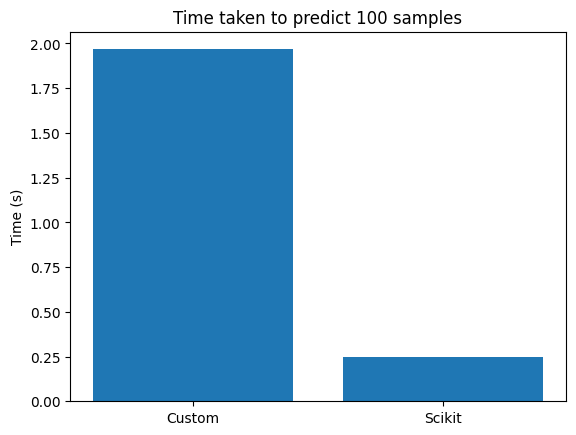

In [42]:
# plot custom_time and scikit_time on a bar chart
plt.bar(['Custom', 'Scikit'], [custom_time, scikit_time])
plt.title('Time taken to predict 100 samples')
plt.ylabel('Time (s)')
plt.show()

In [43]:
del k_nearest_neighbour_scikit, prediction_iris_scikit, accuracy_iris_scikit, k_nearest_neighbour_iris_custom, predictions_iris_custom, accuracy_iris_custom

### Conformal Prediction

In [44]:
same_class_dist, other_class_dist = calculate_distance(X_train_iris, y_train_iris) # calculate the distance between the same class and other class
p_values: list[float] = calculate_p_value(same_class_dist, other_class_dist) # calculate the p-value of the distance between the same class and other class
conformal_prediction_iris: list[bool] = calculate_conformal_prediction(X_train_iris, y_train_iris, X_test_iris, 0.05) # calculate the conformal prediction of the test data
alpha: float = calculate_alpha(p_values, 0.05) # calculate the alpha value
conformal_prediction_iris_alpha: list[bool] = calculate_conformal_prediction(X_train_iris, y_train_iris, X_test_iris, alpha) # calculate the conformal prediction of the test data

In [45]:
print("Average p-value: ", np.mean(p_values))
print("Average false p-value for `alpha = 0.05` iris dataset: ", alpha)
print("Conformal prediction: ", np.mean(conformal_prediction_iris))
print("Conformal prediction for `alpha = 0.05` iris dataset: ", np.mean(conformal_prediction_iris_alpha))

Average p-value:  0.22701569783776976
Average false p-value for `alpha = 0.05` iris dataset:  0.06192235189296758
Conformal prediction:  1.0
Conformal prediction for `alpha = 0.05` iris dataset:  1.0


In [46]:
del same_class_dist, other_class_dist, p_values, conformal_prediction_iris, alpha, conformal_prediction_iris_alpha

## Ionosphere

### Loading Dataset

In [47]:
X_ionosphere = np.genfromtxt("ionosphere.txt", delimiter=',', dtype='int') 
X_ionosphere = X_ionosphere[:, :-1] 
y_ionosphere = np.genfromtxt("ionosphere.txt", delimiter=',', dtype='int')
y_ionosphere = y_ionosphere[:, -1]

### Splitting Dataset

In [48]:
X_train_ionosphere, X_test_ionosphere, y_train_ionosphere, y_test_ionosphere = train_test_split(X_ionosphere, y_ionosphere, random_state=2022)

### Checking Dataset

In [49]:
print("Iris Training Set Features Size: ", X_ionosphere.shape)
print("Iris Training Set Labels Size:   ", y_ionosphere.shape)

Iris Training Set Features Size:  (351, 34)
Iris Training Set Labels Size:    (351,)


In [50]:
# print(X_ionosphere)
# print(y_ionosphere)

### Checking Nearest Neighbours Algorithms

#### K-Nearest Neighbours

##### `K = 3`

- The K-Nearest algorithm is initialized and 3 is passed as the number of neighbours required
- The the 2 sets that need to be tested are passed (fit)

In [51]:
k_nearest_neighbour_ionosphere: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3)
k_nearest_neighbour_ionosphere.fit(X_ionosphere, y_ionosphere)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [52]:
predictions_ionosphere: list = k_nearest_neighbour_ionosphere.predict(X_ionosphere)
compare_ionosphere: DataFrame = pd.DataFrame({'True Labels': y_ionosphere, 'Predicted Labels': predictions_ionosphere})
accuracy_ionosphere: float = k_nearest_neighbour_ionosphere.score(X_ionosphere, y_ionosphere)
error_rate_ionosphere: float = 1 - accuracy_ionosphere
total_number_of_errors_ionosphere: int = sum(compare_ionosphere['True Labels'] != compare_ionosphere['Predicted Labels'])

In [53]:
print_dataset_properties(predictions_ionosphere, accuracy_ionosphere, compare_ionosphere, total_number_of_errors_ionosphere)

Predictions:  [1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

##### `K = 1`

- The K-Nearest algorithm is initialized and 1 is passed as the number of neighbours required
- The the 2 sets that need to be tested are passed (fit)

In [54]:
k_nearest_neighbour_ionosphere: K_Nearest_Neighbours = K_Nearest_Neighbours(k=1)
k_nearest_neighbour_ionosphere.fit(X_ionosphere, y_ionosphere)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [55]:
predictions_ionosphere: list = k_nearest_neighbour_ionosphere.predict(X_ionosphere)
compare_ionosphere: DataFrame = pd.DataFrame({'True Labels': y_ionosphere, 'Predicted Labels': predictions_ionosphere})
accuracy_ionosphere: float = k_nearest_neighbour_ionosphere.score(X_ionosphere, y_ionosphere)
error_rate_ionosphere: float = 1 - accuracy_ionosphere
total_number_of_errors_ionosphere: int = sum(compare_ionosphere['True Labels'] != compare_ionosphere['Predicted Labels'])

In [56]:
print_dataset_properties(predictions_ionosphere, accuracy_ionosphere, compare_ionosphere, total_number_of_errors_ionosphere)

Predictions:  [1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [57]:
del k_nearest_neighbour_ionosphere, predictions_ionosphere, compare_ionosphere, accuracy_ionosphere, error_rate_ionosphere

#### 1 Nearest Neighbour

- The 1-Nearest algorithm is initialized
- The the 2 sets that need to be tested are passed (fit)

In [58]:
one_nearest_neighbour_ionosphere: One_Nearest_Neighbours = One_Nearest_Neighbours()
one_nearest_neighbour_ionosphere.fit(X_ionosphere, y_ionosphere)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [59]:
predictions_ionosphere: list = one_nearest_neighbour_ionosphere.predict(X_ionosphere)
compare_ionosphere = pd.DataFrame({'True Labels': y_ionosphere, 'Predicted Labels': predictions_ionosphere})
accuracy_ionosphere: float = one_nearest_neighbour_ionosphere.score(X_ionosphere, y_ionosphere)
error_rate_ionosphere: float = 1 - accuracy_ionosphere
total_number_of_errors_ionosphere: int = sum(compare_ionosphere['True Labels'] != compare_ionosphere['Predicted Labels'])

In [60]:
print_dataset_properties(predictions_ionosphere, accuracy_ionosphere, compare_ionosphere, total_number_of_errors_ionosphere)

Predictions:  [1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [61]:
del one_nearest_neighbour_ionosphere, predictions_ionosphere, compare_ionosphere, accuracy_ionosphere, error_rate_ionosphere

#### 3 Nearest Neighbour

- The 3-Nearest algorithm is initialized
- The the 2 sets that need to be tested are passed (fit)

In [62]:
three_nearest_neighbours_ionosphere: Three_Nearest_Neighbours = Three_Nearest_Neighbours()
three_nearest_neighbours_ionosphere.fit(X_ionosphere, y_ionosphere)

- Predict labels 
- Compare prediction with actual values 
- Compute accuracy of the prediction
- Compute the error rate
- Compute the total number of errors in the prediction

In [63]:
predictions_ionosphere: list = three_nearest_neighbours_ionosphere.predict(X_ionosphere)
compare_ionosphere: DataFrame = pd.DataFrame({'True Labels': y_ionosphere, 'Predicted Labels': predictions_ionosphere})
accuracy_ionosphere: float = three_nearest_neighbours_ionosphere.score(X_ionosphere, y_ionosphere)
error_rate_ionosphere: float = 1 - accuracy_ionosphere
total_number_of_errors_ionosphere: int = sum(compare_ionosphere['True Labels'] != compare_ionosphere['Predicted Labels'])

In [64]:
print_dataset_properties(predictions_ionosphere, accuracy_ionosphere, compare_ionosphere, total_number_of_errors_ionosphere)

Predictions:  [1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [65]:
del three_nearest_neighbours_ionosphere, predictions_ionosphere, compare_ionosphere, accuracy_ionosphere, error_rate_ionosphere

### Comparing Nearest Neighbour Algorithms

#### K-Nearest Neighbour (`k = 1`) vs 1-Nearest Neighbour 

**K-Nearest Neighbour**

In [66]:
k_nearest_neighbour_ionosphere: K_Nearest_Neighbours = K_Nearest_Neighbours(k=1)
k_nearest_neighbour_ionosphere.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_k: list = k_nearest_neighbour_ionosphere.predict(X_test_ionosphere)
accuracy_iris_k: float = k_nearest_neighbour_ionosphere.score(X_test_ionosphere, y_test_ionosphere)

**One Nearest Neighbour**

In [67]:
one_nearest_neighbour_ionosphere: One_Nearest_Neighbours = One_Nearest_Neighbours()
one_nearest_neighbour_ionosphere.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_1: list = one_nearest_neighbour_ionosphere.predict(X_test_ionosphere)
accuracy_ionosphere_1: float = one_nearest_neighbour_ionosphere.score(X_test_ionosphere, y_test_ionosphere)

**Comparing Results**

- Both the predictions and the accuracy return true which means that the KNN and 1NN work exactly the same way and return the same values

In [68]:
print("Predictions: ", compare_lists(predictions_ionosphere_k, predictions_ionosphere_1))
print("Accuracy: ", accuracy_iris_k == accuracy_ionosphere_1)

Predictions:  True
Accuracy:  True


In [69]:
del k_nearest_neighbour_ionosphere, predictions_ionosphere_k, accuracy_iris_k, one_nearest_neighbour_ionosphere, predictions_ionosphere_1, accuracy_ionosphere_1

#### K-Nearest Neighbour (`k = 3`) vs 3-Nearest Neighbour

**K-Nearest Neighbour**

In [70]:
k_nearest_neighbour_ionosphere: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3)
k_nearest_neighbour_ionosphere.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_k: list = k_nearest_neighbour_ionosphere.predict(X_test_ionosphere)
accuracy_iris_k: float = k_nearest_neighbour_ionosphere.score(X_test_ionosphere, y_test_ionosphere)

**3-Nearest Neighbour**

In [71]:
three_nearest_neighbours_ionosphere: Three_Nearest_Neighbours = Three_Nearest_Neighbours()
three_nearest_neighbours_ionosphere.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_3: list = three_nearest_neighbours_ionosphere.predict(X_test_ionosphere)
accuracy_ionosphere_3: float = three_nearest_neighbours_ionosphere.score(X_test_ionosphere, y_test_ionosphere)

**Comparing Results**

- Both the predictions and the accuracy return true which means that the KNN and 3NN work exactly the same way and return the same values

In [72]:
print("Predictions: ", compare_lists(predictions_ionosphere_k, predictions_ionosphere_3))
print("Accuracy: ", accuracy_iris_k == accuracy_ionosphere_3)

Predictions:  True
Accuracy:  True


In [73]:
del k_nearest_neighbour_ionosphere, predictions_ionosphere_k, accuracy_iris_k, three_nearest_neighbours_ionosphere, predictions_ionosphere_3, accuracy_ionosphere_3

#### Comparing Custom K-Nearest Neighbour Algorithm to `scikit` Built-In Implementation

**SciKit Learn Implementation**

In [74]:
k_nearest_neighbour_ionosphere_scikit: KNeighborsClassifier = KNeighborsClassifier(n_neighbors=3)
k_nearest_neighbour_ionosphere_scikit.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_scikit: list = k_nearest_neighbour_ionosphere_scikit.predict(X_test_ionosphere)
accuracy_ionosphere_scikit: float = k_nearest_neighbour_ionosphere_scikit.score(X_test_ionosphere, y_test_ionosphere)

**Custom Implementation**

In [75]:
k_nearest_neighbour_ionosphere_custom: K_Nearest_Neighbours = K_Nearest_Neighbours(k=3)
k_nearest_neighbour_ionosphere_custom.fit(X_train_ionosphere, y_train_ionosphere)

predictions_ionosphere_custom: list = k_nearest_neighbour_ionosphere_custom.predict(X_test_ionosphere)
accuracy_ionosphere_custom: float = k_nearest_neighbour_ionosphere_custom.score(X_test_ionosphere, y_test_ionosphere)

**Comparing Results**

- Both the predictions and the accuracy return true which means that the custom KNN and the SciKit KNN work exactly the same way and return the same values

In [76]:
print("Predictions: ", compare_lists(predictions_ionosphere_scikit, predictions_ionosphere_custom))
print("Accuracy: ", accuracy_ionosphere_scikit == accuracy_ionosphere_custom)

Predictions:  True
Accuracy:  True


In [77]:
del k_nearest_neighbour_ionosphere_scikit, predictions_ionosphere_scikit, accuracy_ionosphere_scikit, k_nearest_neighbour_ionosphere_custom, predictions_ionosphere_custom, accuracy_ionosphere_custom

### Conformal Prediction

In [78]:
same_class_dist, other_class_dist = calculate_distance(X_train_ionosphere, y_train_ionosphere)
p_values: list[float] = calculate_p_value(same_class_dist, other_class_dist)
conformal_prediction_iris: list[bool] = calculate_conformal_prediction(X_train_ionosphere, y_train_ionosphere, X_test_ionosphere, 0.05)
alpha: float = calculate_alpha(p_values, 0.05)
conformal_prediction_iris_alpha: list[bool] = calculate_conformal_prediction(X_train_ionosphere, y_train_ionosphere, X_test_ionosphere, alpha)

/tmp/ipykernel_4398/2363363583.py:43: RuntimeWarning: invalid value encountered in double_scalars
  p_values.append(element_same / (element_other + element_same)) # calculate the p-value


In [79]:
print("Average p-value: ", np.mean(p_values))
print("Average false p-value for `alpha = 0.05` iris dataset: ", alpha)
print("Conformal prediction: ", np.mean(conformal_prediction_iris))
print("Conformal prediction for `alpha = 0.05` iris dataset: ", np.mean(conformal_prediction_iris_alpha))

Average p-value:  nan
Average false p-value for `alpha = 0.05` iris dataset:  0.5
Conformal prediction:  1.0
Conformal prediction for `alpha = 0.05` iris dataset:  0.0


# Comparing Sorting Algorithms

In [80]:
import random
import timeit

In [81]:
random_numbers: list[float] = [random.random() for _ in range(100)]

In [82]:
arg_sort: float = timeit.timeit("Sorting.arg_sort(random_numbers.copy())", globals=globals(), number=1000)
merge_sort: float = timeit.timeit("Sorting.merge_sort(random_numbers.copy())", globals=globals(), number=1000)
quick_sort: float = timeit.timeit("Sorting.quick_sort(random_numbers.copy())", globals=globals(), number=1000)
heap_sort: float = timeit.timeit("Sorting.heap_sort(random_numbers.copy())", globals=globals(), number=1000)
bubble_sort: float = timeit.timeit("Sorting.bubble_sort(random_numbers.copy())", globals=globals(), number=1000)
selection_sort: float = timeit.timeit("Sorting.selection_sort(random_numbers.copy())", globals=globals(), number=1000)
insertion_sort: float = timeit.timeit("Sorting.insertion_sort(random_numbers.copy())", globals=globals(), number=1000)
arg_partition: float = timeit.timeit("Sorting.arg_partition(random_numbers.copy())", globals=globals(), number=1000)

In [83]:
print("Arg Sort:\t", arg_sort)
print("Merge Sort:\t", merge_sort)
print("Quick Sort:\t", quick_sort)
print("Heap Sort:\t", heap_sort)
print("Bubble Sort:\t", bubble_sort)
print("Selection Sort:\t", selection_sort)
print("Insertion Sort:\t", insertion_sort)
print("Arg Partition:\t", arg_partition)

Arg Sort:	 0.009481659000016407
Merge Sort:	 0.3235935980000022
Quick Sort:	 0.13123982500002285
Heap Sort:	 0.34423587500003805
Bubble Sort:	 0.7118691530000092
Selection Sort:	 0.44889439600001424
Insertion Sort:	 0.6752922850000118
Arg Partition:	 0.012655942999970193


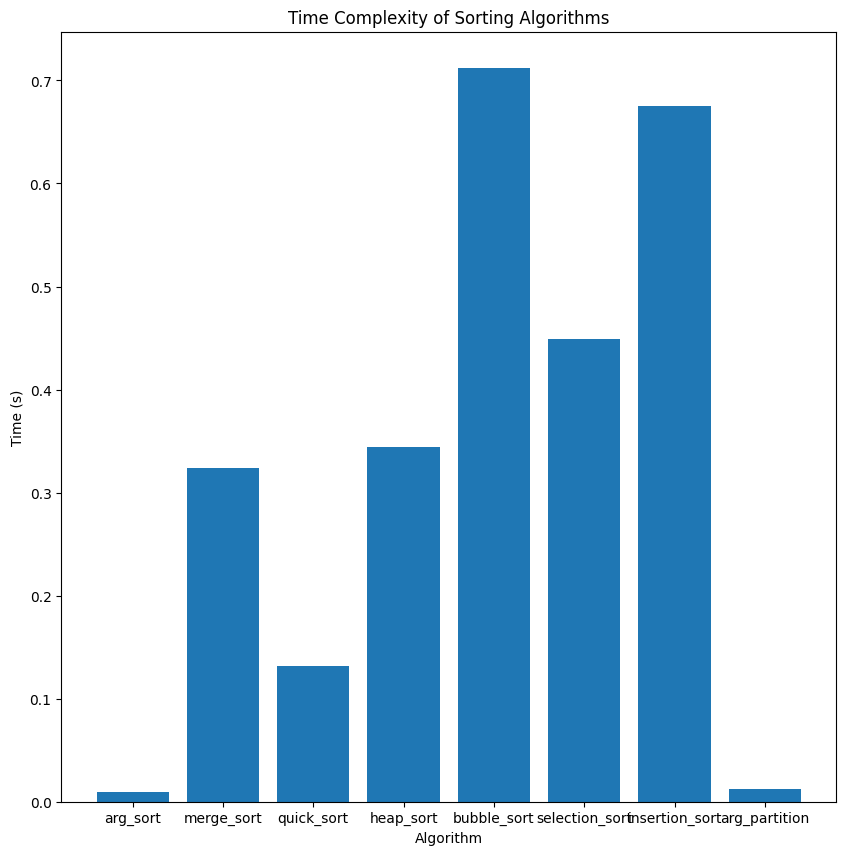

In [84]:
plt.figure(figsize=(10, 10))
plt.title("Time Complexity of Sorting Algorithms")
plt.xlabel("Algorithm")
plt.ylabel("Time (s)")
plt.bar(["arg_sort", "merge_sort", "quick_sort", "heap_sort", "bubble_sort", "selection_sort", "insertion_sort", "arg_partition"], [arg_sort, merge_sort, quick_sort, heap_sort, bubble_sort, selection_sort, insertion_sort, arg_partition])
plt.show()

- The results clearly show that the arg_sort and arg_partition algorithms are the most efficient